In [ ]:
# pip install --quiet scvi-tools

In [1]:
# !pip install scDREAMER
import scDREAMER

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scib
import louvain

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [4]:
import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [5]:
# setting seed for reproducibility
np.random.seed(666)
tf.set_random_seed(666)
random.seed(666)
tf2.random.set_seed(666)
tf2.keras.utils.set_random_seed(666)

In [6]:
import anndata
adata = anndata.read_h5ad("../lung_atlas_public.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [7]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
adata.obs['celltype'] = pd.read_csv("../R_lung_atlas/labels/missing_and_mixing_at_edge_lung_atlas_50_obs.csv")['new_labels'].values

In [9]:
adata.obs['celltype']

index
ACATAGATAGGC                                                             Type 2
CCAGCTTAGGTT                                                             Type 2
TCATAGAGTCCT                                                             Type 2
TAAGGACGAAAT                                                             Type 2
GCAGAATGCTGG                                                             Type 2
                                                                        ...    
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG     Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC     Mast cell
LungTranscriptome7239213_GACTGCGTCCTGCCAT                            Macrophage
LungTranscriptome7239218_GCTGCGACATTCACTT                             Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TTAGGACGTGACGGTA     Mast cell
Name: celltype, Length: 29256, dtype: object

In [10]:
# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'celltype']].head(100)

,batch,cell_type,celltype
index,,,
ACATAGATAGGC,B1,Type 2,Type 2
CCAGCTTAGGTT,B1,Type 2,Type 2
TCATAGAGTCCT,B1,Type 2,Type 2
TAAGGACGAAAT,B1,Secretory,Type 2
GCAGAATGCTGG,B1,Type 2,Type 2
...,...,...,...
TAACCGAGCCTT,B1,Type 2,unknown
GTTAACCATCTC,B1,Type 2,Type 2
GAGGTTTCGGCC,B1,Type 2,Ionocytes


In [11]:
adata

AnnData object with n_obs × n_vars = 29256 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'n_genes', 'n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [12]:
adata.write('./labels_for_new_methods/lung_atlas_missing_at_edge_50.h5ad')

## scDREAMER
scDREAMER takes h5ad file directly as input.


Leaning rate to use for small data vs large input data: 
learning_rate = {
    "Immune_Human": {"lr_ae": 0.0002, "lr_dis": 0.0007},  # Small Datasets
    "Human_Mouse": {"lr_ae": 0.0001, "lr_dis": 0.00001},
}  # Big Datasets >= 0.5 million cells

it does the data preprocessing by its own function: 
	•	read_h5ad: This function reads the data from an .h5ad file using Scanpy and performs several preprocessing steps:
	•	Normalization: Total counts per cell are normalized to 10,000.
	•	Log Transformation: A log transformation is applied to the data.
	•	Highly Variable Genes: The top 2,000 highly variable genes are selected based on the Seurat method, using the batch key for batch correction.
	•	Data Preparation: The data is then converted into a dense or sparse matrix, depending on sparseIP.
	•	One-Hot Encoding: Batch information and cell type labels are one-hot encoded, which will be used later in the model.
	•	load_gene_mtx: This function loads the dataset, processes it using read_h5ad, and prepares it for input into the model. It handles transformations, normalization, and returns the processed data along with labels and batch information.

Loading dataset
Preprocessing...
here [16 16 16 ...  9 10 10]
Shape self.data_train: (29256, 2000)
Shape self.data_test: (29256, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2016), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 26), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ./labels_for_new_methods/lung_atlas_missing_at_edge_50.h5ad ... 
Epoch : [0] ,  a_loss = 669.7250
Epoch : [10] ,  a_loss = 545.1235
Epoch : [20] ,  a_loss = 525.0831
Epoch : [30] ,  a_loss = 512.7376
Epoch : [40] ,  a_lo

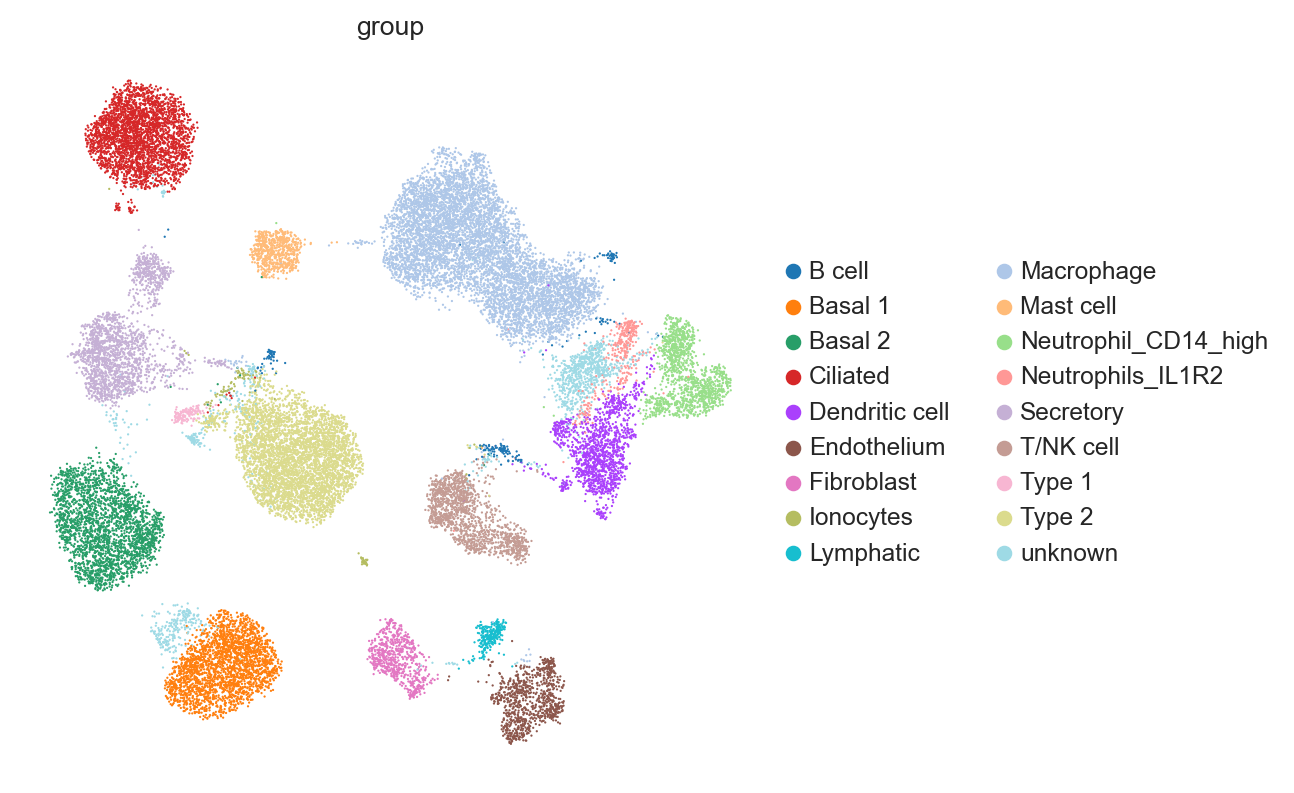

None


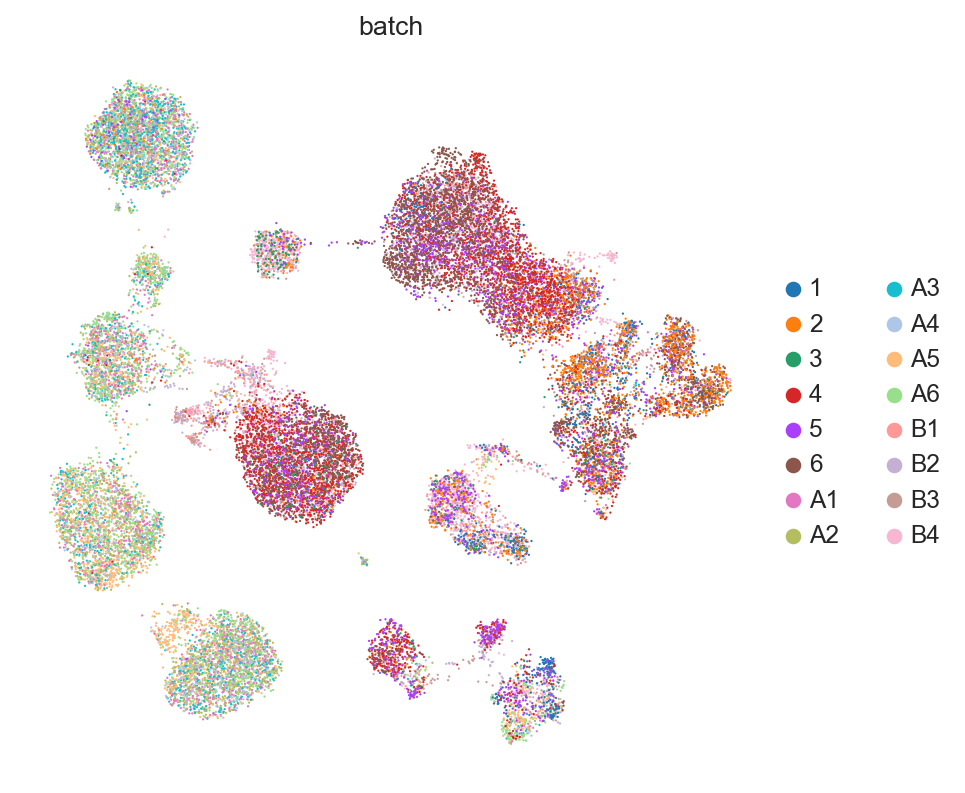

None


In [13]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "Lung_atlas_missing_50"
dataset_path = "./labels_for_new_methods/lung_atlas_missing_at_edge_50.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=240,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()